# This file shows examples of how to make custom plots

## This file can be modified and/or copied to suit your needs.


The plots shown here are the plots used in the SimStorm paper, for now.

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from utility_programs.read_routines import GITM, SAMI

from utility_programs import filters, plot_help

import argparse
from tqdm.auto import tqdm
from utility_programs.plot_help import UT_from_Storm_onset
import utility_programs.plotting_routines as pr
from utility_programs import filters
import os
import datetime
import pandas as pd

from aetherpy.utils.time_conversion import ut_to_lt

from scipy import signal

import aacgmv2

import importlib

import geopandas
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


In [2]:
# Debugging

import utility_programs
pr = importlib.reload(utility_programs.plotting_routines)
filters = importlib.reload(utility_programs.filters)

In [3]:
dtime_storm_start=datetime.datetime(2011,5,21,12,0)
# we'll need this a lot.

## Panel of Joule Heating & Particle Heating 10 mins after storm onset.

This needs to be done a little differently since the data isn't split into hemisphereres naturally

In [204]:
gitm_dtimes, gitmgrid, gitmbins, gitmvars = GITM.read_gitm_into_nparrays(
    "/glade/u/home/abukowski/scratch/GITM-simstorm-run1/run2/UA/data",  t_start_idx=1, t_end_idx=1,return_vars=True, gitm_file_pattern='2DANC*.bin', dtime_storm_start=dtime_storm_start)

100%|██████████| 24/24 [00:01<00:00, 19.51it/s]


In [205]:
gitmbins.shape

(24, 12, 90, 180, 1)

In [206]:
lons

[1, -90]

In [207]:
lats = np.unique(gitmgrid['latitude'])
lons = np.unique(gitmgrid['longitude'])
new_shape = [len(gitm_dtimes), len(lons), len(lats)]

maskNorth = ((lats > 45))
maskSouth = ((lats < -45))

In [208]:
gitmvars

['LocalTime',
 'SolarZenithAngle',
 'VerticalTEC',
 'AltIntJouleHeating(W/m2)',
 'AltIntHeatingTransfer(W/m2)',
 'AltIntEuvHeating(W/m2)',
 'AltIntPhotoElectronHeating(W/m2)',
 'AltIntChamicalHeating(W/m2)',
 'AltIntRadCooling(W/m2)',
 'AltIntCO2Cooling(W/m2)',
 'AltIntNOCooling(W/m2)',
 'AltIntOCooling(W/m2)']

In [209]:
for i, n in enumerate(gitmvars):
    if 'Heat' in n or 'Cool' in n:
        print(i,n)

3 AltIntJouleHeating(W/m2)
4 AltIntHeatingTransfer(W/m2)
5 AltIntEuvHeating(W/m2)
6 AltIntPhotoElectronHeating(W/m2)
7 AltIntChamicalHeating(W/m2)
8 AltIntRadCooling(W/m2)
9 AltIntCO2Cooling(W/m2)
10 AltIntNOCooling(W/m2)
11 AltIntOCooling(W/m2)


In [210]:
ut_to_lt(gitm_dtimes, lons)

array([[23.13333333, 23.4       , 23.66666667, ..., 22.33333333,
        22.6       , 22.86666667],
       [23.21666667, 23.48333333, 23.75      , ..., 22.41666667,
        22.68333333, 22.95      ],
       [23.3       , 23.56666667, 23.83333333, ..., 22.5       ,
        22.76666667, 23.03333333],
       ...,
       [ 0.88333333,  1.15      ,  1.41666667, ...,  0.08333333,
         0.35      ,  0.61666667],
       [ 0.96666667,  1.23333333,  1.5       , ...,  0.16666667,
         0.43333333,  0.7       ],
       [ 1.05      ,  1.31666667,  1.58333333, ...,  0.25      ,
         0.51666667,  0.78333333]])

In [211]:
gitmvars[3], gitmvars[5]

('AltIntJouleHeating(W/m2)', 'AltIntEuvHeating(W/m2)')

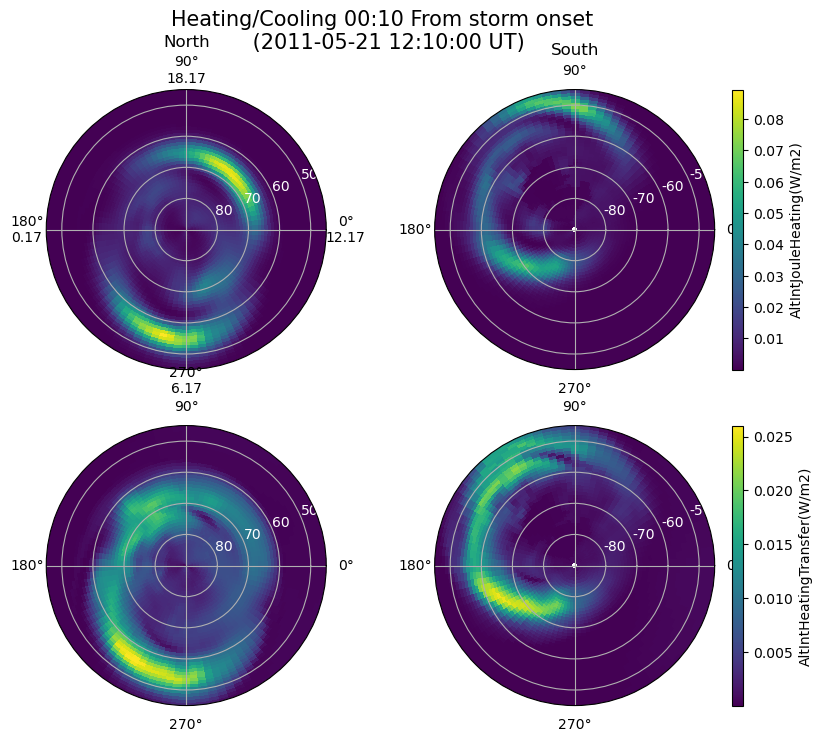

In [264]:
nrows = 1
ncols = 2
t_index = 14

dtime = gitm_dtimes[t_index]

# Do it automatically:
nvars = [3,4]
nrows=len(nvars)
data = []
titles=['North','South']
colorbar_labels=[]

for var in nvars:
    data.append(gitmbins[t_index,var,:,:,:].reshape([len(lons), len(lats)]))
    colorbar_labels.append(gitmvars[var])
                


"""
data=[0,0] 
# Don't set data in Column! 
# We'll plot same data, other hemisphere in the columns
data[0] = gitmbins[t_index,3,:,:,:].reshape([len(lons), len(lats)])
data[1] = gitmbins[t_index,5,:,:,:].reshape([len(lons), len(lats)])


titles=[0,0]
titles[0] = "North"
titles[1] = "South"
# Only needed in first row!


colorbar_labels=[0 for i in range(nrows)]
"""


# fig = plt.figure(figsize=(10, 8.5))
fig, axes = plt.subplots(nrows,ncols, figsize=(10,4*nrows),subplot_kw={'projection':'polar'},)



fig.suptitle('Heating/Cooling %s From storm onset \n (%s UT)'
                % (UT_from_Storm_onset(
                    dtime, dtime_storm_start),
                str(dtime)), fontsize=15)



for row in range(nrows):
    for col in range(ncols):
        
        
        
        if col == 0:
            r, theta = np.meshgrid(90-lats[maskNorth], lons)
            axes[row,col].pcolor(np.deg2rad(theta), r,
                             data[row][:, maskNorth].copy(),
                             vmin=np.min(data[row]),
                             vmax=np.max(data[row]),)
            ylabels = ['80', '70', '60', '50']
        elif col ==1:
            r, theta = np.meshgrid(90+lats[maskSouth], lons)
            cb = axes[row,col].pcolor(np.deg2rad(theta), r,
                             data[row][:, maskSouth].copy(),
                             vmin=np.min(data[row]),
                             vmax=np.max(data[row]),)
            
            fig.colorbar(cb, label=colorbar_labels[row], aspect=25)
            ylabels = ['-80', '-70', '-60', '-50']
        
        
        
        
        axes[row,col].set_xticks(np.arange(0, 2*np.pi, np.pi/2))
        axes[row,col].set_yticks(np.arange(10, 50, 10))
        axes[row,col].set_yticklabels(ylabels, color='white')
        lts = ut_to_lt([dtime],[0,90,180,270])
        
        if row == col ==0:
            axes[row,col].set_xticklabels(['0°\n'+str(lts[0][0].round(2)),
                                       '90°\n'+str(lts[0][1].round(2)),
                                       '180°\n'+str(lts[0][2].round(2)),
                                       '270°\n'+str(lts[0][3].round(2))+'\n',])
        
        
        if row == 0:
            axes[row,col].set_title(titles[col])
        
        

# fig.tight_layout(pad=1)

plt.show()
# plt.savefig('all-heatingcooling-before-storm')
plt.close()

### MANUAL OVERRIDE


To just show a single type of heating:

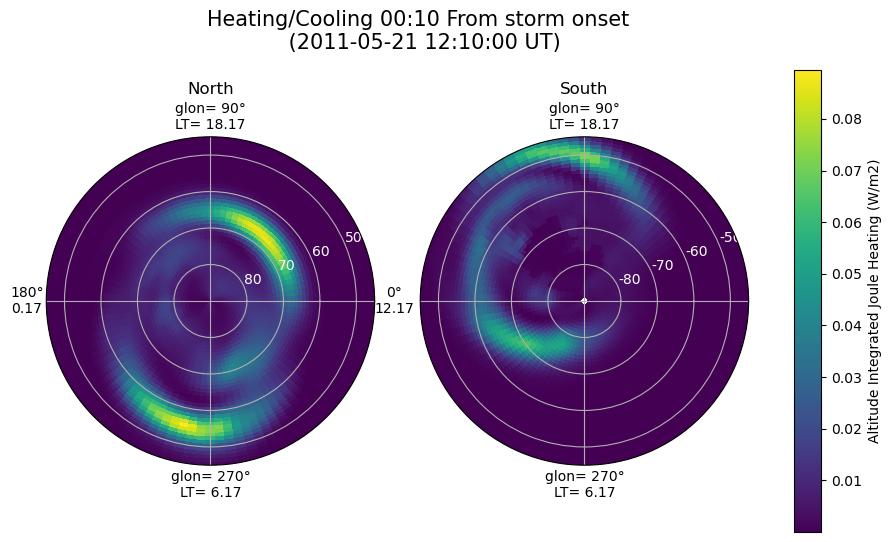

In [319]:
fig = plt.figure(figsize=(10, 6))

var=3 #variable number

data = gitmbins[t_index,var,:,:,:].reshape([len(lons), len(lats)])
colorbar_labels = 'Altitude Integrated Joule Heating (W/m2)' 

fig.suptitle('Heating/Cooling %s From storm onset \n (%s UT)'
                % (UT_from_Storm_onset(
                    dtime, dtime_storm_start),
                str(dtime)), fontsize=15)

gs1 = GridSpec(nrows=1, ncols=3, wspace=.2, hspace=.1, width_ratios=(8.5,8.5,.7))
ax0 = fig.add_subplot(gs1[0, 0], projection='polar')
ax1 = fig.add_subplot(gs1[0, 1], projection='polar')
ax2 = fig.add_subplot(gs1[0, 2])


r, theta = np.meshgrid(90-lats[maskNorth], lons)
ax0.pcolor(np.deg2rad(theta), r,
                 data[:, maskNorth].copy(),
                 vmin=np.min(data),
                 vmax=np.max(data),)
ylabels = ['80', '70', '60', '50']


ax0.set_xticks(np.arange(0, 2*np.pi, np.pi/2))
ax0.set_yticks(np.arange(10, 50, 10))
ax0.set_yticklabels(ylabels, color='white')
lts = ut_to_lt([dtime],[0,90,180,270])
ax0.set_title('North')

# if row == col ==0:
ax0.set_xticklabels(['0°\n'+str(lts[0][0].round(2)),
                               'glon= 90°\nLT= '+str(lts[0][1].round(2)),
                               '180°\n'+str(lts[0][2].round(2)),
                               '\nglon= 270°\nLT= '+str(lts[0][3].round(2))+'\n',])


r, theta = np.meshgrid(90+lats[maskSouth], lons)
cb = ax1.pcolor(np.deg2rad(theta), r,
                 data[:, maskSouth].copy(),
                 vmin=np.min(data),
                 vmax=np.max(data),)

fig.colorbar(cb, label=colorbar_labels, cax=ax2)
ylabels = ['-80', '-70', '-60', '-50']



ax1.set_xticks(np.arange(0, 2*np.pi, np.pi/2))
ax1.set_yticks(np.arange(10, 50, 10))
ax1.set_yticklabels(ylabels, color='white')
ax1.set_title('South')
# if row == col ==0:
ax1.set_xticklabels(['',
       'glon= 90°\nLT= '+str(lts[0][1].round(2)),
       '',
       '\nglon= 270°\nLT= '+str(lts[0][3].round(2))+'\n',])




plt.show()
# plt.savefig("/glade/u/home/abukowski/figures/fig3-out")
plt.close()


In [230]:
lts.shape

(1, 4)

## GITM Rho Maps

In [320]:
gitm_dtimes, gitmgrid, gitmbins, gitmvars = GITM.read_gitm_into_nparrays(
    "/glade/u/home/abukowski/scratch/GITM-simstorm-run1/run2/UA/data", dtime_storm_start, t_start_idx=1, t_end_idx=4,return_vars=True, cols=['Rho'])

100%|██████████| 60/60 [03:04<00:00,  3.08s/it]


In [321]:
gitm_dtimes[14], gitm_dtimes[20], gitm_dtimes[44], gitmvars[0]

(datetime.datetime(2011, 5, 21, 12, 10),
 datetime.datetime(2011, 5, 21, 12, 40),
 datetime.datetime(2011, 5, 21, 14, 40),
 'Rho')

In [322]:
alt = 662 # km
plot_timedelta = 6
plot_start = 14
var = 0

nrows = 3
ncols = 2


alt_idx = np.argmin(np.abs(np.unique(gitmgrid['altitude']) - alt*1000))


In [323]:
fits = filters.make_fits(gitmbins)
percents = 100*(gitmbins - fits)/gitmbins

# del fits, gitmbins


In [324]:
data = []
titles = []
i=0

for row in range(nrows):
    data.append([])
    titles.append([])

    for col in range(ncols):
        
        time_idx_here = plot_start + i*plot_timedelta

        
        data[row].append(percents[time_idx_here,var,:,:,alt_idx].copy())
        titles[row].append(plot_help.UT_from_Storm_onset(gitm_dtimes[time_idx_here], dtime_storm_start))
        i+=1


del percents

In [325]:
titles[0][0] += ' from Storm Onset'

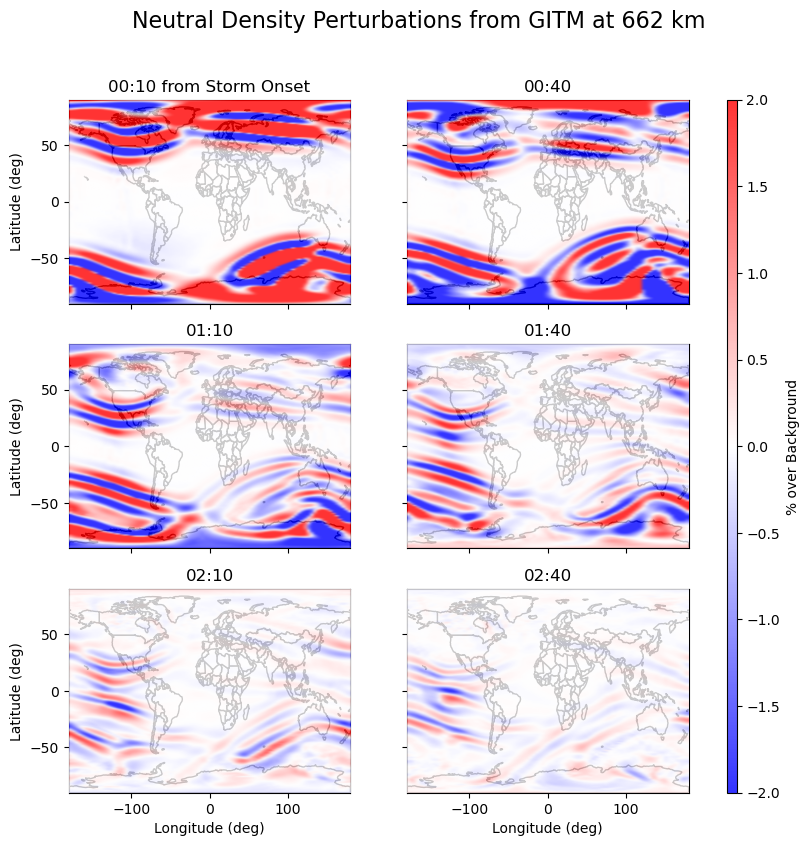

In [328]:

fig, axes = plt.subplots(nrows,ncols, figsize=(10,3*nrows), sharex=True, sharey=True)

for row in range(nrows):
    for col in range(ncols):
        im = pr.draw_map(data[row][col], cbarlims=[-2,2], save_or_show="return", ax=axes[row,col], title=str(row), cmap='bwr')
        
        axes[row,col].set_title(titles[row][col])
        
        if col == 0:
            axes[row,col].set_ylabel("Latitude (deg)")

        if row == nrows-1:
            axes[row,col].set_xlabel("Longitude (deg)")


fig.suptitle('Neutral Density Perturbations from GITM at 662 km       ', fontsize=16, ha='center')
# spaces needed to center properly with the colorbar existing.
    
fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical",
             label = '% over Background', aspect=75)
fig.align_xlabels()

# plt.savefig("/glade/u/home/abukowski/figures/fig1-out")
plt.show()
plt.close()

## GITM Rho Keograms

In [331]:
t_start = 2
t_end = 8

In [332]:
gitm_dtimes, gitmgrid, gitmbins, gitmvars = GITM.read_gitm_into_nparrays(
    "/glade/u/home/abukowski/scratch/GITM-simstorm-run1/run2/UA/data", dtime_storm_start, 
    t_start_idx=t_start, t_end_idx=t_end,return_vars=True, cols='Rho')

100%|██████████| 120/120 [05:58<00:00,  2.98s/it]


In [333]:
nrows=2
ncols=2

alts=[225,663]
lons=[1,-90]

In [334]:
alts_real = []
alt_idxs = []
lons_real = []
lon_idxs = []

for i in range(len(alts)):
    altidx=np.argmin(np.abs(np.unique(gitmgrid['altitude']) - alts[i]*1000))
    alt_idxs.append(altidx)
    alts_real.append(np.unique(gitmgrid['altitude'])[altidx])
    
    lonidx=np.argmin(np.abs(np.unique(gitmgrid['longitude']) - lons[i]))
    lon_idxs.append(lonidx)
    lons_real.append(np.unique(gitmgrid['longitude'])[lonidx])
    

In [335]:
fits = filters.make_fits(gitmbins)
percents = 100*(gitmbins - fits)/gitmbins

# del fits, gitmbins

In [336]:
data = []
titles = []

for row in range(nrows):
    data.append([])
    titles.append([])

        
for row in range(nrows):
    
    for col in range(ncols):
        data[row].append(percents[:,0,lon_idxs[row],:,alt_idxs[col]].copy())
        titles[row].append('lon= %i deg, alt= %i km' %(lons_real[row], alts_real[col]/1000))

# del percents

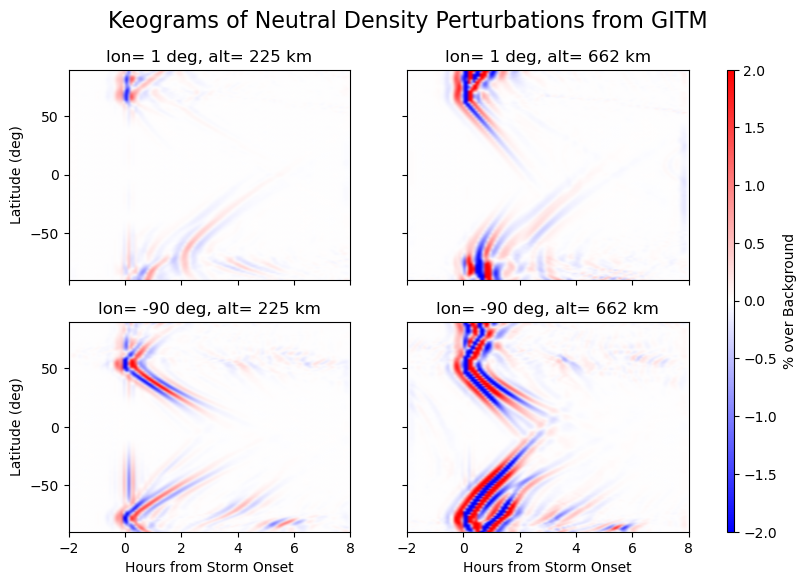

In [339]:
fig, axes = plt.subplots(nrows,ncols, figsize=(10,3*nrows), sharex=True, sharey=True)

for row in range(nrows):
    for col in range(ncols):
        im = pr.make_a_keo(np.array(data[row][col]), cbarlims=[-2,2], save_or_show="return", ax=axes[row,col], title=str(row),
                           cmap='bwr', extent=[-t_start, t_end, -90,90])
        
        axes[row,col].set_title(titles[row][col])
        
        if col == 0:
            axes[row,col].set_ylabel("Latitude (deg)")

        if row == nrows-1:
            axes[row,col].set_xlabel("Hours from Storm Onset")


fig.suptitle('Keograms of Neutral Density Perturbations from GITM          ', fontsize=16, ha='center')
# spaces needed to center properly with the colorbar existing.
    
fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical",
             label = '% over Background', aspect=75)
fig.align_xlabels()


# plt.savefig("/glade/u/home/abukowski/figures/fig2-out")
plt.show()
plt.close()

## SAMI3 TEC keograms (in geographic coordinates)


- *NOTE: to run this, the TEC and BtoG post-processing scripts must be run first*


In [340]:
samidata, times = SAMI.read_sami_dene_tec(
    "/glade/u/home/abukowski/scratch/GITM-simstorm-run1/sami-gitm-coupled/",
    datetime.datetime(2011,5,20), dtime_storm_start,)

In [341]:
start = np.argmin(np.abs(times-datetime.datetime(2011,5,21,10))/pd.Timedelta(1, 'minute'))
end = np.argmin(np.abs(times-datetime.datetime(2011,5,21,20))/pd.Timedelta(1, 'minute'))

In [342]:
end, start

(528, 408)

In [343]:
lons=[90,-178,2,-90]

In [344]:
fitssami = filters.make_fits(samidata['data']['tec'])
percent=100*(samidata['data']['tec']-fitssami)/samidata['data']['tec']

grid=samidata['grid']

del samidata, fitssami

In [345]:
percent.shape

(625, 80, 100)

In [346]:
glons = []
glats = []
nlons = grid['glon'].shape[0]
nlats = grid['glat'].shape[2]
for lat in range(nlats):
    for lon in range(nlons):
        glon_i = grid['glon'][lon,0,lat]
        if glon_i > 180:
            glons.append(glon_i - 360)
        else:
            glons.append(glon_i)
        glats.append(grid['glat'][lon,0,lat])

glons = np.array(glons)


In [347]:
glons.shape

(8000,)

In [350]:
data = [[],[]]
titles = [[],[]]

i=0

for row in range(nrows):
    for col in range(ncols):
        sel_pts = np.where(
                    (np.abs(glons - lons[i]) < 3) &
                    (np.abs(glats) < 65) )[0]
        raw = []
        for t in range(start, end):
            raw.append(percent[t,:,:].copy().T.flatten()[sel_pts])
        data[row].append(np.array(raw))
        titles[row].append('glon= %i deg' %(lons[i]))
        
        i+=1
        
      

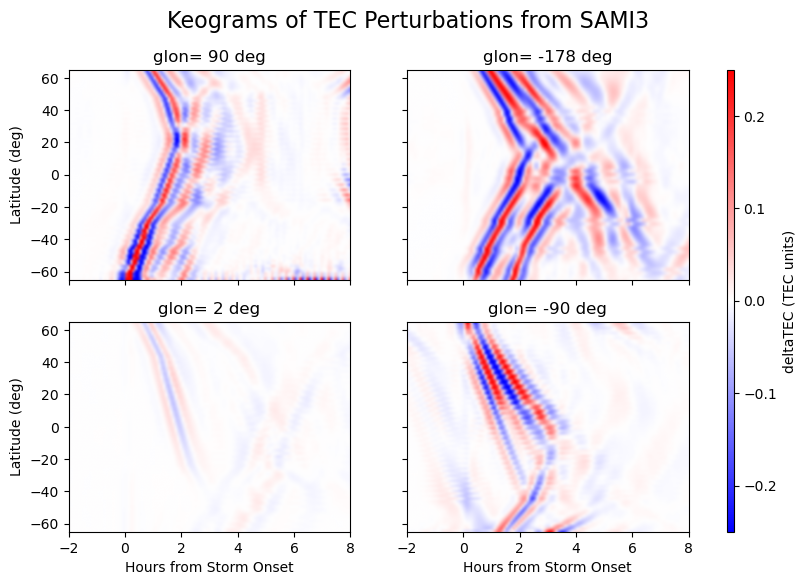

In [353]:
fig, axes = plt.subplots(nrows,ncols, figsize=(10,3*nrows), sharex=True, sharey=True)

for row in range(nrows):
    for col in range(ncols):
        im = pr.make_a_keo(data[row][col], cbarlims=[-.25,.25],
                           save_or_show="return", ax=axes[row,col], cmap='bwr', extent=[-2,8,-90,90],
                          ylims=[-65,65])
        
        axes[row,col].set_title(titles[row][col])
        
        if col == 0:
            axes[row,col].set_ylabel("Latitude (deg)")

        if row == nrows-1:
            axes[row,col].set_xlabel("Hours from Storm Onset")


fig.suptitle('Keograms of TEC Perturbations from SAMI3          ', fontsize=16, ha='center')
# spaces needed to center properly with the colorbar existing.
    
fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical",
             label = 'deltaTEC (TEC units)', aspect=75)
fig.align_xlabels()


# plt.savefig("/glade/u/home/abukowski/figures/fig4-out")
plt.show()
plt.close()

## SAMI3 plots along a magntic longitude (magnetic coordinates)

In [354]:
samidata, times = SAMI.read_sami_data(
    "/glade/u/home/abukowski/scratch/GITM-simstorm-run1/sami-gitm-coupled/",
    dtime_sim_start=datetime.datetime(2011,5,20), dtime_storm_start=dtime_storm_start,
    t_start_idx=1, t_end_idx=4, cols=['edens'])

(80, 72, 256, 60) 60 420 480


In [355]:
samidata['data']['edens'].shape

(80, 72, 256, 60)

In [356]:
mlon=317
plot_timedelta = 6
plot_start = 14

In [357]:
mlons = np.unique(samidata['grid']['mlon']).round(2)
mlon_idx = np.argmin(np.abs(mlons-mlon))

mask = (samidata['grid']['mlon'].round(2) == mlons[mlon_idx])

x = samidata['grid']['mlat'][mask]
y = samidata['grid']['alt'][mask]

In [358]:
def make_filter(params=None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60)  # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5  # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos


def remove_background(time_series, sos, axis = 0):

    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series, axis)

    return filtered_data

In [359]:
sos = make_filter()
filt = remove_background(samidata['data']['edens'][mask, :].copy(), sos, axis=1)

percent = 100*(samidata['data']['edens'][mask,:] - filt)/samidata['data']['edens'][mask,:]


In [366]:
nrows=3
ncols=2

In [367]:
data = []
titles = []

i=0

for row in range(nrows):
    data.append([])
    titles.append([])
    for col in range(ncols):
        
        time_idx_here = plot_start + i*plot_timedelta

        raw = []
        data[row].append(percent[:,time_idx_here])
        
        dtime=times[time_idx_here]
        
        mlt = aacgmv2.wrapper.convert_mlt(
                        mlon, dtime, m2a=False).round(2)[0]
        ut=UT_from_Storm_onset(dtime, dtime_storm_start)
        
        titles[row].append('MLT = %s, %s' %(str(mlt), ut))
        
        i+=1

In [368]:
titles[0][0] += ' from Storm Onset'

In [369]:
plot_start + i*plot_timedelta

50

In [370]:
data[0][0].shape

(18432,)

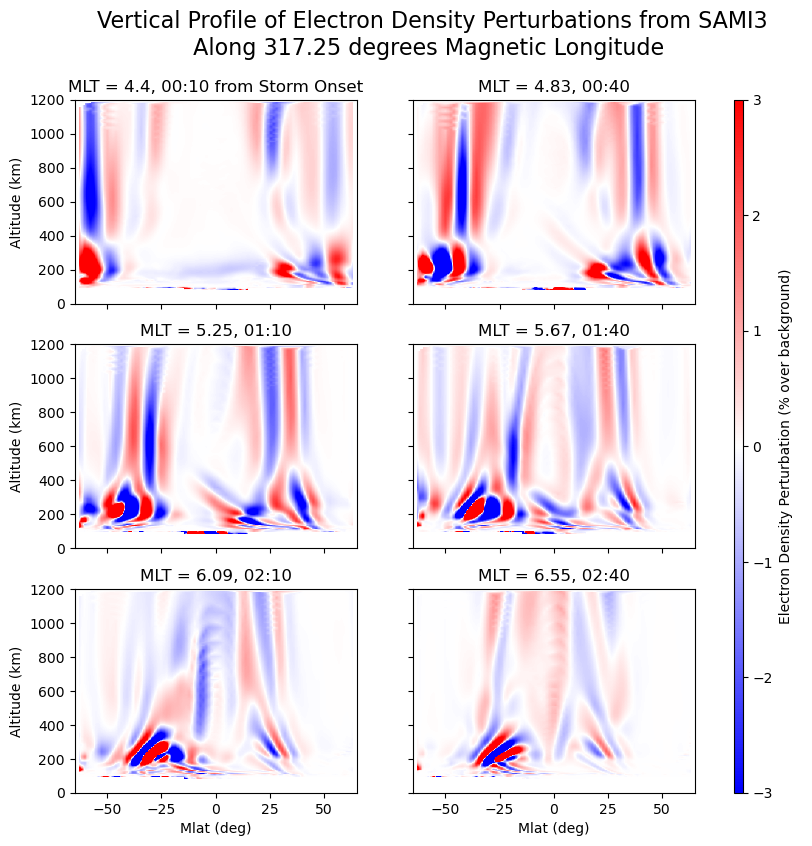

In [376]:
fig, axes = plt.subplots(nrows,ncols, figsize=(10,3*nrows), sharex=True, sharey=True)

for row in range(nrows):
    for col in range(ncols):
        im = pr.draw_field_line_plot(x, y, data[row][col], 
                                     interpolate=True, ax = axes[row,col],
                                     save_or_show='return', cbar_lims=[-3,3], 
                                    cmap='bwr')
        
        axes[row,col].set_title(titles[row][col])

        
        if col == 0:
            axes[row,col].set_ylabel("Altitude (km)")

        if row == nrows-1:
            axes[row,col].set_xlabel("Mlat (deg)")


fig.suptitle('Vertical Profile of Electron Density Perturbations from SAMI3     \n Along 317.25 degrees Magnetic Longitude       ', fontsize=16, ha='center')
# spaces needed to center properly with the colorbar existing.
    
fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical",
             label = 'Electron Density Perturbation (% over background)', aspect=75)
fig.align_xlabels()


# plt.savefig("/glade/u/home/abukowski/figures/fig5-out")
plt.show()
plt.close()